In [1]:
import pandas as pd
import glob
import networkx as nx
import numpy as np
import os
import seaborn as sns

import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42

os.getcwd()

'/work/big_project/080/github/cellratio_corr_network'

In [2]:
df = pd.read_table('../data/Fig1_8type_73subcelltype_meta_new.csv', sep=",", index_col=0)
Tissue = 'CIN3-PCIN3'

df = df[df['Group'].isin(['PCIN3', 'CIN3'])]
df['cc'] = 1

df = df.groupby(['Sample', 'type', 'celltype']).sum()['cc'].reset_index()
df=df[~df['type'].isin(['Tumor', 'Epithelial'])]
df.head(2)

/tmp/ipykernel_982172/1210551522.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['Sample', 'type', 'celltype']).sum()['cc'].reset_index()


,Sample,type,celltype,cc
0,CC14CIN3,DC,C1_cDC1_CLEC9A,1
1,CC14CIN3,DC,C2_cDC2_CLEC10A,3


In [3]:
Tissue

'CIN3-PCIN3'

In [4]:
df.query('type=="Bcell"')['celltype'].unique()

array(['C1_Bn', 'C2_Bn_MHC', 'C3_Bm_GC', 'C4_Bm_IgM+', 'C5_Bm_IgM-',
       'C6_Plasma_IgA', 'C7_Plasma_IgG', 'C8_Plasma_Stress'], dtype=object)

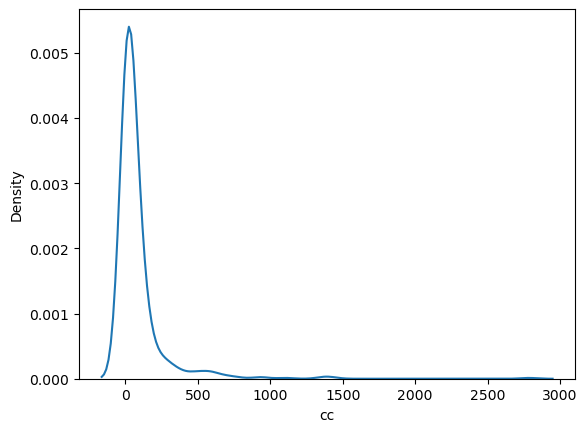

In [5]:
ax = sns.kdeplot(df['cc'])
#ax.set_title(f'{Tissue} celltype cell number density')

In [6]:
## 记录的是每个celltype 涉及的 样本数
df_celltype_sample = df[['Sample', 'celltype']].groupby(['celltype']).count()
#df_celltype_sample['Sample']

## 以样本细胞总数为分母，去掉在少于一半样本出现的 细胞类型展示负相关性前10，正相关性取阈值

In [7]:
## 记录的是每个celltype 在每个sample里的细胞数
df_celltype_sample = df[['Sample', 'celltype']].groupby(['celltype']).count()
## 如果一个celltype 低于在一半样本中出现，则去除该细胞类型
df_celltype_sample['mean_rat'] =  df_celltype_sample['Sample']/len(df['Sample'].unique())

print(f'总细胞类型:{df_celltype_sample.shape[0]}')
#df_celltype_sample = df_celltype_sample.query('mean_rat>=0.5')
print(f'剩余细胞类型:{df_celltype_sample.shape[0]}')

df = df[df['celltype'].isin(df_celltype_sample.index)]
df.head(2)


总细胞类型:59
剩余细胞类型:59


,Sample,type,celltype,cc
0,CC14CIN3,DC,C1_cDC1_CLEC9A,1
1,CC14CIN3,DC,C2_cDC2_CLEC10A,3


In [8]:
df2 = df.groupby(['Sample']).sum()['cc']
df['sample_N'] = 0

for i in df.index:
    df.loc[i, "sample_N"] = df2[df.loc[i, "Sample"]]

df['ratio'] = df['cc']/df['sample_N']

/tmp/ipykernel_982172/2250543885.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['Sample']).sum()['cc']


In [9]:
ratio_mat = df.pivot(index='Sample', columns='celltype', values='ratio')
ratio_mat = ratio_mat.fillna(0)
ratio_corr = ratio_mat.corr(method="pearson", min_periods=1, numeric_only=True)
ratio_mat.shape


(11, 59)

Text(0.5, 1.0, 'CIN3-PCIN3 cell fraction correlation distribution')

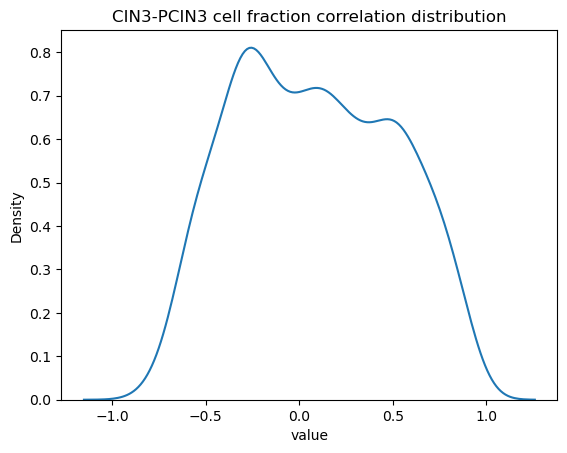

In [10]:
df4net = pd.DataFrame(np.triu(ratio_corr, k=1))
df4net.index = ratio_mat.columns
df4net.columns = ratio_mat.columns
df4net['idid'] = ratio_mat.columns
#del df4net['celltype']
df4net = df4net.melt(id_vars='idid')
df4net = df4net.query('value!=0')

ax = sns.kdeplot(df4net['value'])
#ax.axvline(0.4)
ax.set_title(f'{Tissue} cell fraction correlation distribution')


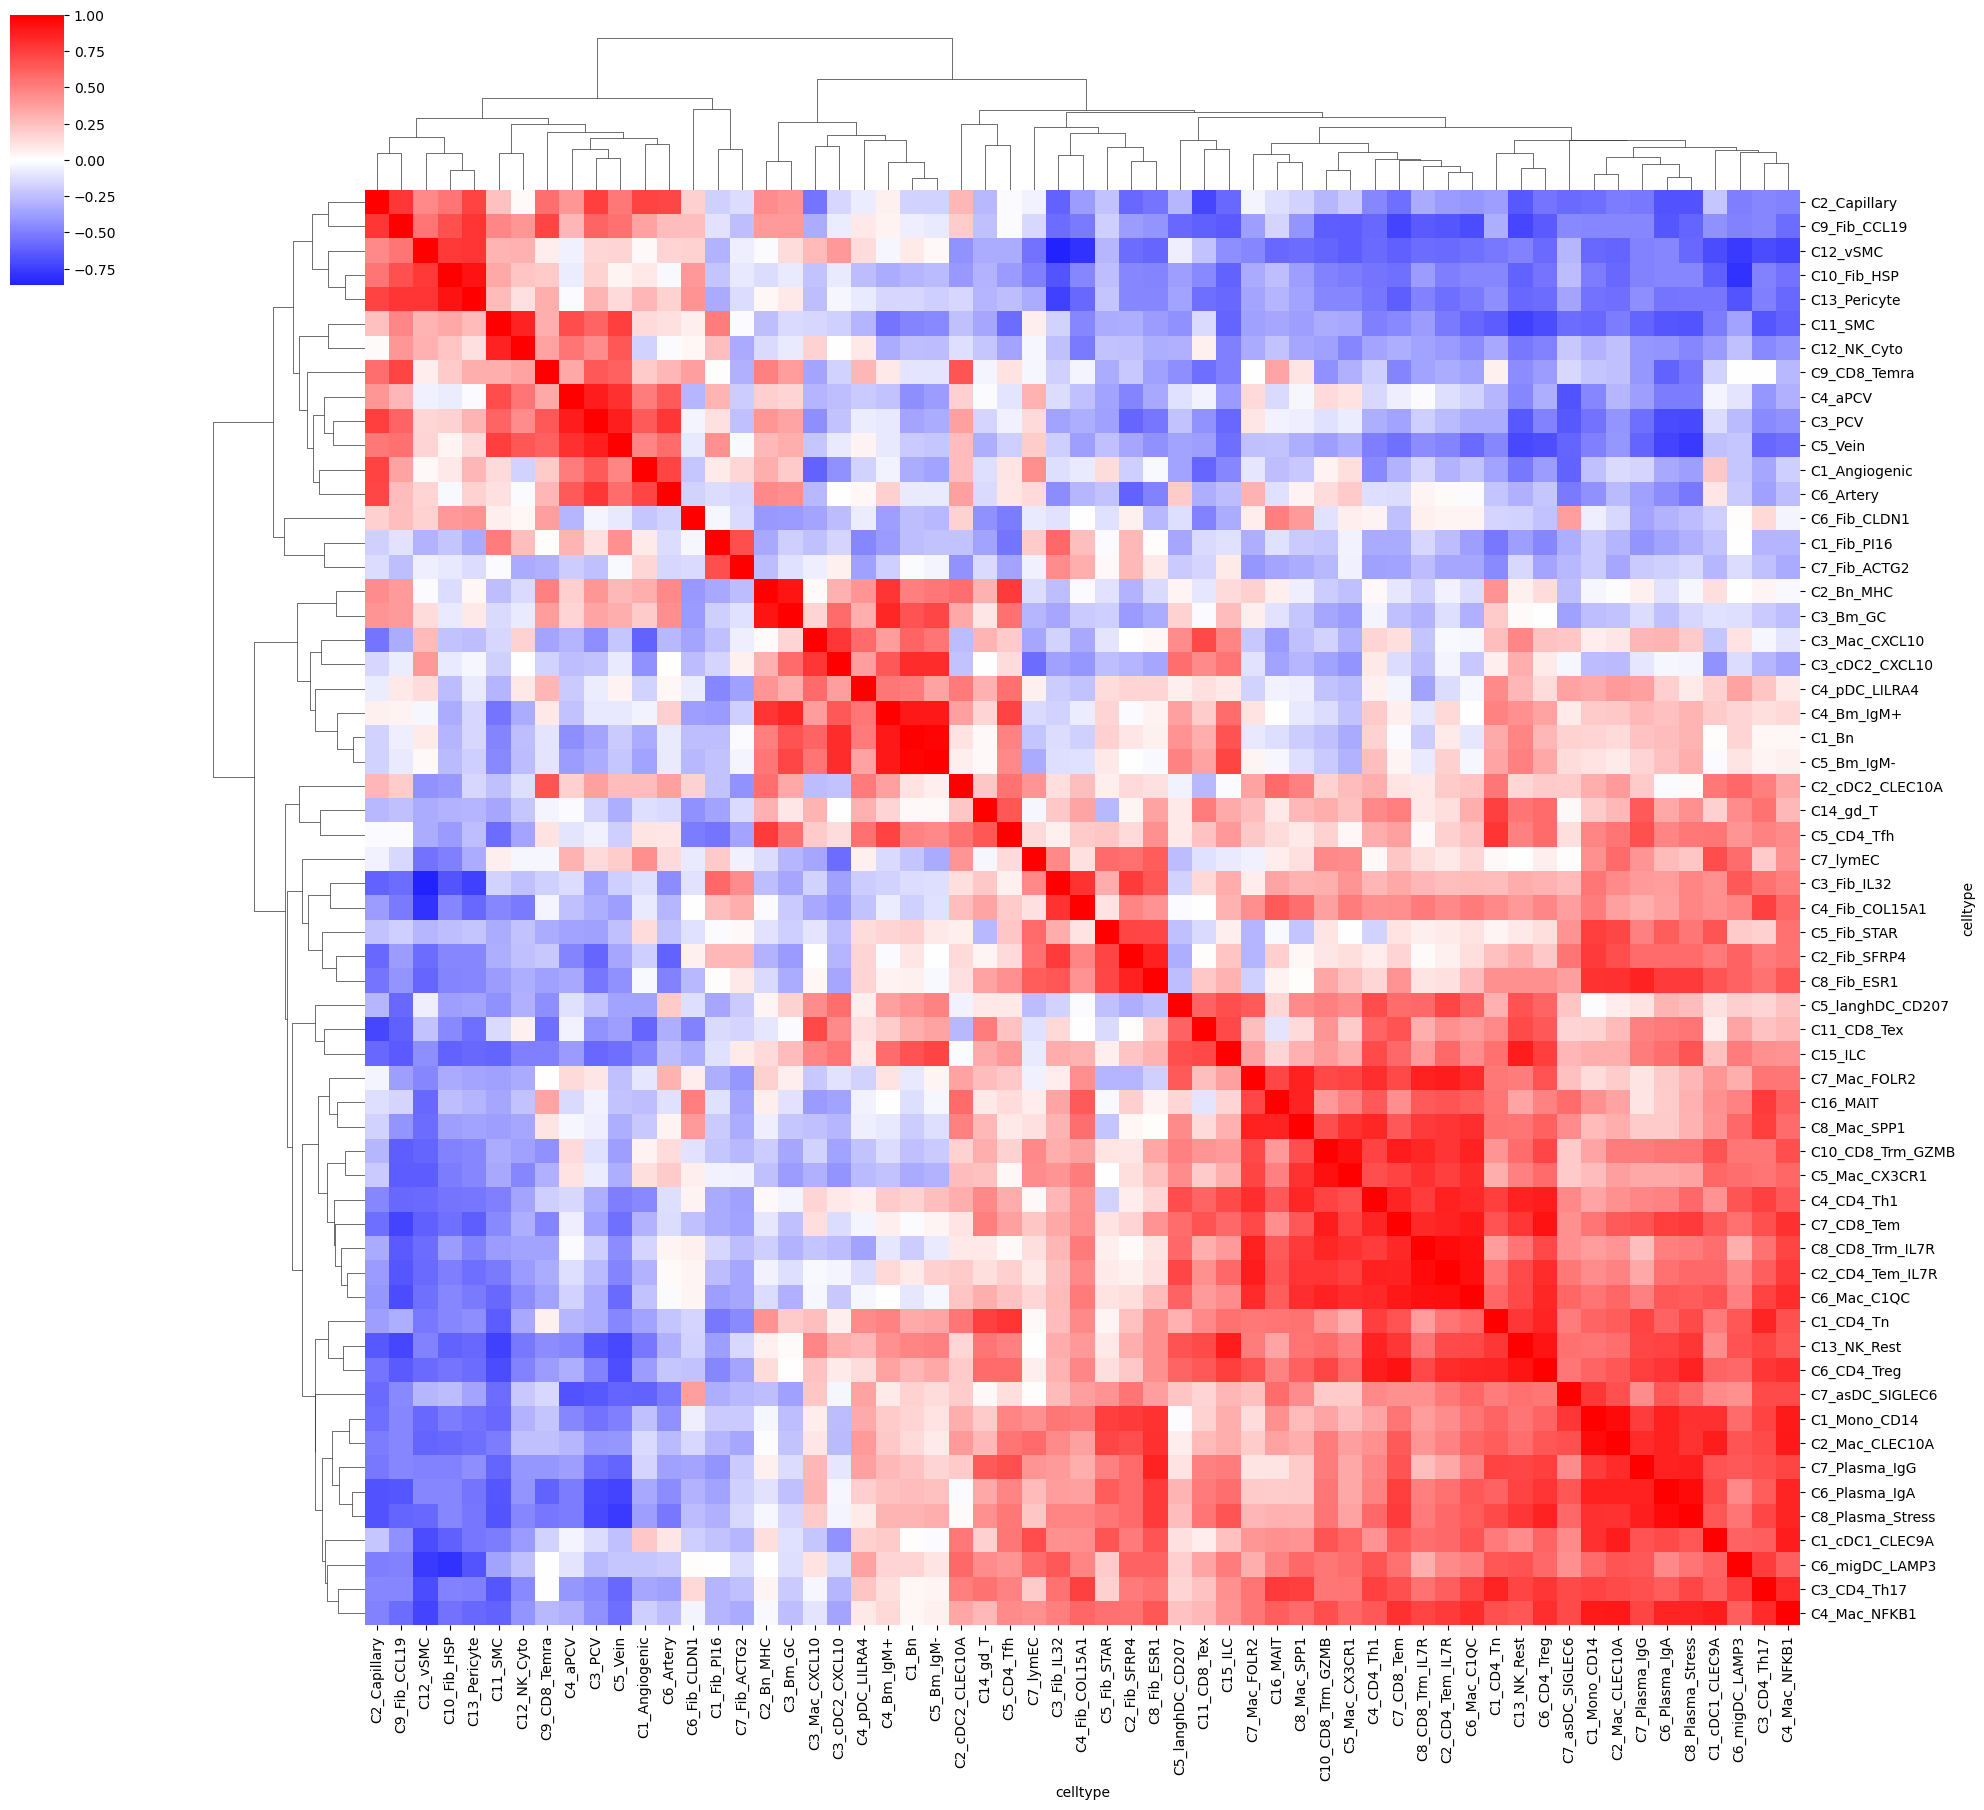

In [12]:
h = sns.clustermap(ratio_corr, 
               figsize=(18, 18), 
               #col_colors=celltype_annotation[['celltype']],
               xticklabels=True,
               yticklabels=True,
               center=0,
               cbar_pos=(-0.1, 0.85, 0.03, 0.15), 
               dendrogram_ratio=0.1, 
               #square=True,
               cmap="bwr")

ax = plt.gca()


#h.savefig(f'{Tissue}_{ratio_mat.shape[1]}celltype_{ratio_mat.shape[0]}sample_ratio_corr_heatmap_byType.pdf')

In [13]:
ratio_corr.index.name = None
ratio_corr.columns.name = None

In [14]:
df['type'].unique()

array(['DC', 'Endothelial', 'Fibroblast', 'Myeloid', 'T_cell', 'Bcell'],
      dtype=object)

In [15]:
ccc = pd.DataFrame({'color': ['#438EC0', '#C3AAD2', '#F7A962',  '#7C53A4', '#97D277', '#E62E27']})
ccc.index = ['Bcell','DC','Endothelial','Fibroblast','Myeloid','T_cell']
display(ccc)

aaa = df.groupby(['type', 'celltype']).sum().reset_index()
aaa.index = aaa['celltype']
aaa['color'] = ccc.loc[aaa['type'], 'color'].to_list()
aaa.head(2)

,color
Bcell,#438EC0
DC,#C3AAD2
Endothelial,#F7A962
Fibroblast,#7C53A4
Myeloid,#97D277
T_cell,#E62E27


/tmp/ipykernel_982172/279296463.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aaa = df.groupby(['type', 'celltype']).sum().reset_index()


,type,celltype,cc,sample_N,ratio,color
celltype,,,,,,
C1_Bn,Bcell,C1_Bn,107,49050,0.025606,#438EC0
C2_Bn_MHC,Bcell,C2_Bn_MHC,98,36532,0.026157,#438EC0


,idid,celltype,value,weight_scale
59,C10_CD8_Trm_GZMB,C10_Fib_HSP,-0.492464,0.492464
118,C10_CD8_Trm_GZMB,C11_CD8_Tex,0.416540,0.416540


(498, 5)

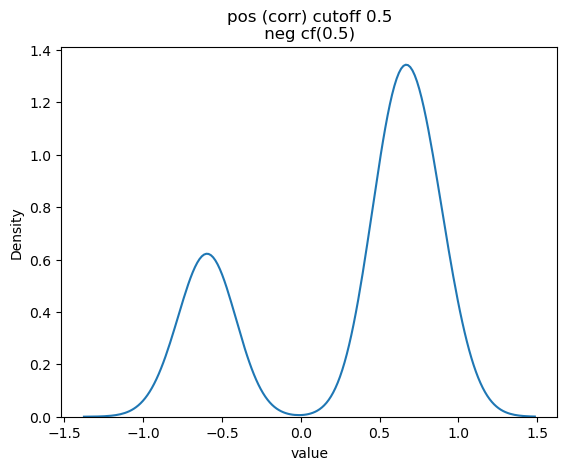

In [16]:
df4net_tmp = df4net.copy()
df4net_tmp['weight_scale'] = abs(df4net_tmp['value'])
display(df4net_tmp.head(2))
#df4net2 = df4net2[df4net2['weight_scale'] > corr_cutoff]

top_negative_corr = 70
#corr_cutoff_plus = 0.5
positive_cutoff = 0.5
df4net_pos = df4net_tmp[df4net_tmp['value'] > positive_cutoff]

#df4net2 = df4net_tmp[df4net_tmp['weight_scale'] > corr_cutoff_plus]
minus_df4net_tmp = df4net_tmp.query('value<0')
#df4net_neg = minus_df4net_tmp.sort_values('value', ascending=True).head(top_negative_corr)
df4net_neg = minus_df4net_tmp.query('value<-0.5')


df4net2 = pd.concat([df4net_pos, df4net_neg], axis=0)

from sklearn.preprocessing import MinMaxScaler  

scaler = MinMaxScaler(feature_range=(0, 0.99))  
df4net2['weight_scale2'] = scaler.fit_transform(df4net2['weight_scale'].values.reshape(-1, 1)).flatten()  
df4net2

ax = sns.kdeplot(df4net2['value'])
ax.set_title(f'pos (corr) cutoff {positive_cutoff}\n neg cf({0.5}) ')
df4net2.shape

In [17]:
df4net2.query('value<0').shape

(143, 5)

In [18]:
def network_G_pos(df_p):
    G = nx.Graph()
    G.clear()

    nodes = pd.DataFrame(list(set(pd.concat([df_p["idid"], df_p["celltype"]], axis=0))))
    nodes.index = range(nodes.shape[0])
    nodes.columns = ['node']

    for i, row in nodes.iterrows():
        G.add_node(row['node'])

    for i, row in df_p.iterrows():
        G.add_edge(row['idid'], row['celltype'], weight=row['value'], length=row['value'])

    return nodes, G


nodes, G = network_G_pos(df4net2)


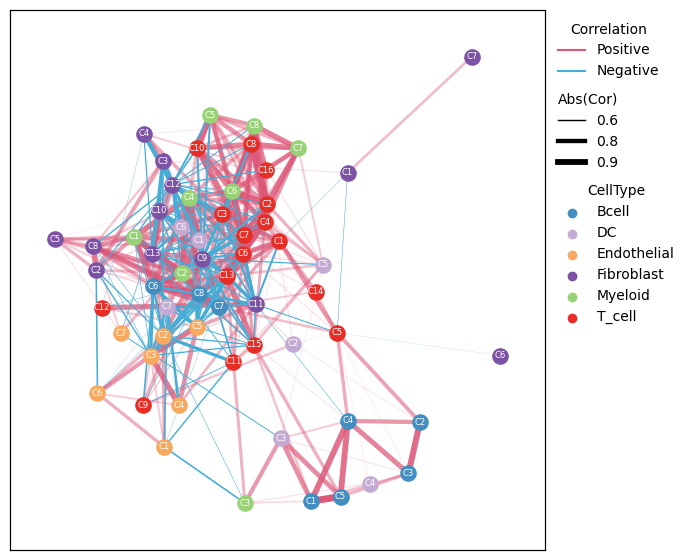

In [21]:
fig, ax = plt.subplots(figsize=(7,5.7))
prog = ['dot', 'twopi', 'sfdp', 'circo', 'fdp']
pos = nx.nx_agraph.graphviz_layout(G, prog=prog[4])

edge_list_plus_corr = [(row['idid'], row['celltype']) for i, row in df4net2.query('value>0').iterrows()]
edge_list_minus_corr = [(row['idid'], row['celltype']) for i, row in df4net2.query('value<0').iterrows()]


edges_plus_corr = nx.draw_networkx_edges(G, pos, 
                       edgelist=edge_list_plus_corr,
                       #edge_color=df4net2.query('value>0')['value'], 
                       width=df4net2.query('value>0')['weight_scale2']*5,
                       #width=2,
                       ax=ax,
                       alpha=df4net2.query('value>0')['weight_scale2'].to_list(),
                       edge_color='#DD5778',
                       style = 'solid')

edges_minus_corr = nx.draw_networkx_edges(G, pos, 
                       edgelist=edge_list_minus_corr,
                       #edge_color=df4net2.query('value<0')['value'], 
                       width=df4net2.query('value<0')['weight_scale2']*5,
                       #width=2,
                       ax=ax,
                       #alpha=df4net2.query('value<0')['weight_scale'].to_list(),
                       edge_color='#45ADD6',
                       style = 'solid')


for i,row in nodes.iterrows():
    nx.draw_networkx_nodes(G, pos, 
                           nodelist=[row['node']], 
                           node_size=120,
                           node_color=aaa.loc[ row['node'],'color'],
                           #alpha=0.5
                          )
 
bbox={'facecolor': 'None', #填充色
      'edgecolor': 'None',#外框色
      'alpha': 0.5, #框透明度
      'pad': 0,#本文与框周围距离
     }
    
#props = dict(boxstyle='round', facecolor='white', alpha=0.5)
props = dict(fontweight='bold')
labels = {i:i.split('_')[0] for i in pos}

labels = nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, font_color='w', bbox=bbox)



############################### add legend
for i,row in aaa[['type', 'color']].drop_duplicates().iterrows():
    ax.scatter(None,None, label=row['type'], color=row['color'])
ax.legend(title='CellType', bbox_to_anchor=(1, 0.7), loc=2, frameon=False)

########### legend 2
axin1 = ax.inset_axes([0, 0, 1, 1])
axin1.set_facecolor('none')

axin1.plot(0,0, label='Positive', color='#DD5778', alpha=1)
axin1.plot(0,0, label='Negative', color='#45ADD6', alpha=1)

axin1.legend(title='Correlation', bbox_to_anchor=(1, 1), loc=2, frameon=False)
axin1.set_axis_off()



########### legend 3
ax2 = ax.twinx()
lg_list = scaler.fit_transform(np.array([df4net2['weight_scale'].describe()['min'], 
                               df4net2['weight_scale'].describe()['max'], 
                               0.6, 
                               0.8, 
                               0.9]).reshape(-1, 1)).flatten()  

ax2.plot(0,0, label='0.6', color='black', alpha=1, linewidth=lg_list[2]*5)
ax2.plot(0,0, label='0.8', color='black', alpha=1, linewidth=lg_list[3]*5)
ax2.plot(0,0, label='0.9', color='black', alpha=1, linewidth=lg_list[4]*5)
ax2.legend(title='Abs(Cor)', bbox_to_anchor=(1, 0.87), loc=2, frameon=False)
ax2.set(yticklabels=[], yticks=[])
ax.set(yticklabels=[], yticks=[])



#plt.axis("off")
plt.tight_layout()

plt.savefig(f'{Tissue}_network_cell_fraction2.pdf')
